In [26]:
import pandas as pd
import numpy as np
import gemmi
import reciprocalspaceship as rs
from tqdm import tqdm
import glob, os
import matplotlib.pyplot as plt

### 0. Path to necessary files

In [5]:
lig_log_path = "./sample_to_smiles_values_only.csv"
data_root = "/n/hekstra_lab/people/minhuan/projects/drug/refine_heavy_benchmarks"

diff_column = "WDF" # or diff
phase_column = "refine_PH2FOFCWT"

### 1. Read the lig log from DK's results

In [6]:
lig_log = pd.read_csv(lig_log_path)
DK_bound = lig_log[lig_log["DK hit?"] > 0].copy()
condition_1 = (DK_bound["# Cl atoms"] + DK_bound["# S atoms"] + DK_bound["# I atoms"] + DK_bound["# Br atoms"] + DK_bound["# P atoms"]) >0
condition_2 = DK_bound["Use"] == 1
DK_bound_heavy = DK_bound[condition_1 & condition_2].copy()

### 2. Auxilliary functions

In [21]:
def get_heavy_cra_list(st, selections='[CL,Br,S,I]'):
    sel = gemmi.Selection('[CL,Br,S,I]')
    sel_model = sel.copy_model_selection(st[0])
    lig_heavy_atoms = [i for i in list(sel_model.all()) if i.residue.name == 'LIG']
    return lig_heavy_atoms

def get_peak_values(cra_list, real_grid):
    # check the highest peak
    a,b,c = np.unravel_index(real_grid.array.argmax(), real_grid.array.shape)
    tmp = real_grid.get_fractional(a,b,c)
    peak_pos = mtz.cell.orthogonalize(gemmi.Fractional(tmp.x, tmp.y, tmp.z))
    dis_lists = []
    peak_values = []
    ops = real_grid.spacegroup.operations()
    for cra in cra_list:
        # Get all equivalent sites
        atom = cra.atom
        eq_points = []
        dis_list = []
        for op in ops:
            SG_mapped=op.apply_to_xyz(real_grid.unit_cell.fractionalize(atom.pos).tolist())
            tmp = SG_mapped-np.floor(np.array(SG_mapped)) # Move into cell
            SG_mapped = gemmi.Fractional(*tmp)
            # print(f"xyz: {SG_mapped[0]:.3f}, {SG_mapped[1]:.3}, {SG_mapped[2]:.3} ") 
            eq_points.append(SG_mapped)
            SG_mapped_orth = real_grid.unit_cell.orthogonalize(SG_mapped)
            dis_list.append(np.sqrt(np.sum(np.array((peak_pos - SG_mapped_orth).tolist())**2)))
        
        # Get the nearest voxel value
        peak_value = []
        for pos in eq_points:
            a = round(pos.x * real_grid.nu)
            b = round(pos.y * real_grid.nv)
            c = round(pos.z * real_grid.nw)
            peak_value.append(real_grid.get_value(a, b, c))
            #print(real_grid.get_value(a, b, c))
        
        dis_lists.append(dis_list)
        peak_values.append(peak_value)
    return dis_lists, peak_values

### 3. Metric for VAE reconstructed diff map

In [22]:
DK_bound_heavy.loc[:, 'initRF_lig_heavy_peak'] = 0.0
DK_bound_heavy.loc[:, 'initRF_is_highest_peak(<5A)'] = 0.0

In [23]:
DK_bound_heavy.loc[:, 'postRF_lig_heavy_peak'] = 0.0
DK_bound_heavy.loc[:, 'postRF_is_highest_peak(<5A)'] = 0.0

In [24]:
for sample in tqdm(DK_bound_heavy["sample"]):
    initRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/PTP1B*.pdb"))[0]
    postRF_pdb = glob.glob(os.path.join(data_root, f"{sample:04}/valdo*.pdb"))[0]
    mtz_path =  glob.glob(os.path.join(data_root, f"{sample:04}/*.mtz"))[0]

    initRF_model = gemmi.read_pdb(initRF_pdb)
    postRF_model = gemmi.read_pdb(postRF_pdb)
    mtz = gemmi.read_mtz_file(mtz_path)
    real_grid = mtz.transform_f_phi_to_map(diff_column, 'refine_PH2FOFCWT', sample_rate=3.0)
    real_grid.normalize()

    initRF_heavy_list = get_heavy_cra_list(initRF_model)
    postRF_heavy_list = get_heavy_cra_list(postRF_model)

    initRF_dis_lists, initRF_peak_values = get_peak_values(initRF_heavy_list, real_grid)
    postRF_dis_lists, postRF_peak_values = get_peak_values(postRF_heavy_list, real_grid)

    initRF_log_peak = np.max(initRF_peak_values)
    initRF_log_ismaxpeak = np.any(np.array(initRF_dis_lists) < 5.0)
    DK_bound_heavy.loc[DK_bound_heavy['sample']==sample, 'initRF_lig_heavy_peak'] = initRF_log_peak
    DK_bound_heavy.loc[DK_bound_heavy['sample']==sample, 'initRF_is_highest_peak(<5A)'] = initRF_log_ismaxpeak

    postRF_log_peak = np.max(postRF_peak_values)
    postRF_log_ismaxpeak = np.any(np.array(postRF_dis_lists) < 5.0)
    DK_bound_heavy.loc[DK_bound_heavy['sample']==sample, 'postRF_lig_heavy_peak'] = postRF_log_peak
    DK_bound_heavy.loc[DK_bound_heavy['sample']==sample, 'postRF_is_highest_peak(<5A)'] = postRF_log_ismaxpeak

100%|██████████| 48/48 [00:04<00:00, 11.04it/s]


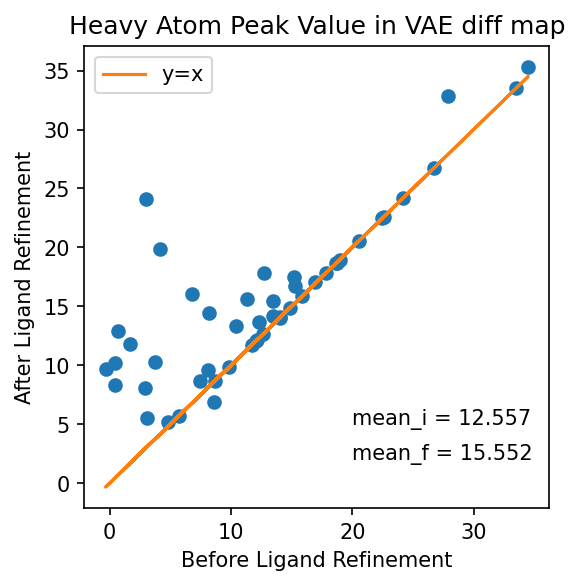

In [42]:
plt.figure(figsize=[4,4], dpi=150)
plt.plot(DK_bound_heavy["initRF_lig_heavy_peak"], DK_bound_heavy["postRF_lig_heavy_peak"], 'o')
plt.plot(DK_bound_heavy["initRF_lig_heavy_peak"], DK_bound_heavy["initRF_lig_heavy_peak"], '-', label='y=x')
plt.xlabel("Before Ligand Refinement")
plt.ylabel("After Ligand Refinement")
plt.legend()
plt.title("Heavy Atom Peak Value in VAE diff map")
plt.text(20, 5, f"mean_i = {DK_bound_heavy['initRF_lig_heavy_peak'].mean():.3f}")
plt.text(20, 2, f"mean_f = {DK_bound_heavy['postRF_lig_heavy_peak'].mean():.3f}")
plt.show()

In [49]:
DK_bound_heavy[DK_bound_heavy["postRF_lig_heavy_peak"] < (DK_bound_heavy["initRF_lig_heavy_peak"]-0.01) ]

,sample,SMILES_string,Number of molecules,# O atoms,# Cl atoms,# S atoms,# P atoms,# Br atoms,# I atoms,DK hit?,HG hit?,Use,initRF_lig_heavy_peak,initRF_is_highest_peak(<5A),postRF_lig_heavy_peak,postRF_is_highest_peak(<5A)
1034,1043,['CNC(=S)NC1CCCCC1'],1,0,0,1,0,0,0,1,0,1,8.586623,True,6.864467,True


In [50]:
DK_bound_heavy[DK_bound_heavy["postRF_is_highest_peak(<5A)"] & ~(DK_bound_heavy["initRF_is_highest_peak(<5A)"]) ]

,sample,SMILES_string,Number of molecules,# O atoms,# Cl atoms,# S atoms,# P atoms,# Br atoms,# I atoms,DK hit?,HG hit?,Use,initRF_lig_heavy_peak,initRF_is_highest_peak(<5A),postRF_lig_heavy_peak,postRF_is_highest_peak(<5A)
813,822,['OC(=O)c1csc(n1)c2ccc(cc2)C(F)(F)F'],1,2,0,1,0,0,0,1,0,1,2.881561,False,8.073840,True
836,845,['CS(=O)(=O)Nc1ccc(Cl)cc1'],1,2,1,1,0,0,0,1,0,1,2.978482,False,24.149994,True
838,847,['CS(=O)(=O)NCc1ccc(Cl)cc1'],1,2,1,1,0,0,0,1,1,1,0.727122,False,12.882751,True
1279,1288,['O=S(=O)(NCc1cccs1)c2ccccc2'],1,2,0,2,0,0,0,1,0,1,1.676234,False,11.834859,True
1643,1652,['Cn1c(c(cn1)Cl)C(=O)N2CCCCC2'],1,1,1,0,0,0,0,1,0,1,7.486748,False,8.647387,True
1948,1957,['CC(=O)N1C[C@@H](CO)[C@@H]2Oc3ccc(Cl)cc3[C@H]...,1,3,1,0,0,0,0,1,0,1,14.070189,False,14.070189,True


In [51]:
DK_bound_heavy[~DK_bound_heavy["postRF_is_highest_peak(<5A)"] & (DK_bound_heavy["initRF_is_highest_peak(<5A)"]) ]

,sample,SMILES_string,Number of molecules,# O atoms,# Cl atoms,# S atoms,# P atoms,# Br atoms,# I atoms,DK hit?,HG hit?,Use,initRF_lig_heavy_peak,initRF_is_highest_peak(<5A),postRF_lig_heavy_peak,postRF_is_highest_peak(<5A)
